<a href="https://colab.research.google.com/github/minerva-mcgonagraph/iliad/blob/master/flu_vax_viz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualizing Flu Activity and Vaccination Rates

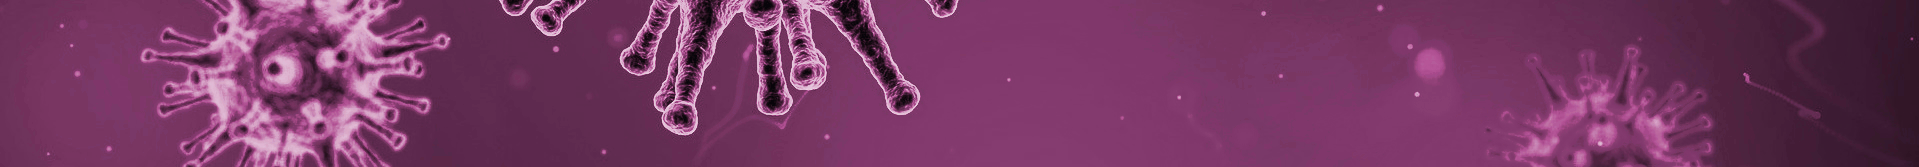

Are you getting the flu shot this year? Every fall that question begets a myriad of responses. "Of course!" or "Yeah, eventually, I guess," or "Why would I, it doesn't even work," or even "Everyone knows it's just a way for big pharma to make money!" Misinformation has its contributions: the vaccine itself gives you the flu; the vaccine doesn't prevent the flu and has bad side effects; or the vaccine completely prevents the flu, so if you get sick it can't be the flu or that's proof the vaccine is fake.

A full statistical analysis can provide the numbers to show vaccine efficacy, but sometimes you just want to play with the data yourself. The CDC collects data on [flu activity](https://gis.cdc.gov/grasp/fluview/main.html) and [vaccination rates](https://www.cdc.gov/flu/fluvaxview/reportshtml/trends/index.html) every season, where each season runs approximately from October of one year to September the next, and we can visualize this data to see if there are any obvious patterns. The data included here ranges from the 2010-2011 to 2018-2019 seasons to avoid skew from H1N1 (2009-2010) and COVID-19 (2019-2020).

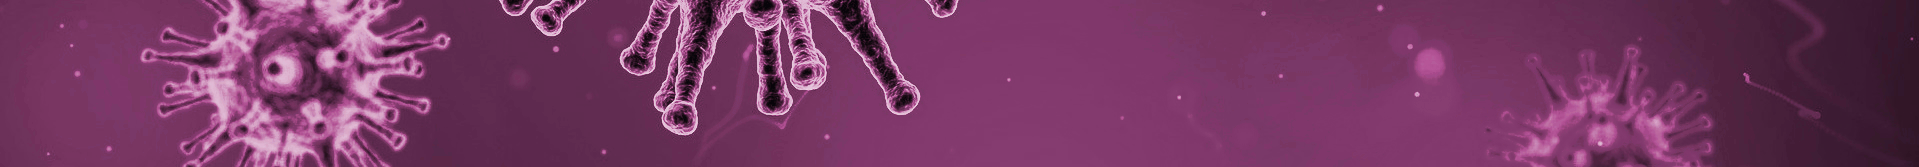

To use these visualizations, press play in each box. The first preps the data behind the scenes. Then press play in a visualization and select a season or state from the dropdown menu. The chart will automatically update with each new selection.

In [27]:
#@title 1. Press play to prep the data!

#import libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as tick
#from matplotlib.dates import DateFormatter
from datetime import datetime
import seaborn as sns
%matplotlib inline
from ipywidgets import widgets, interactive

"""Data sources:
Vaccine rates: https://www.cdc.gov/flu/fluvaxview/reportshtml/trends/index.html
Flu activity levels: https://gis.cdc.gov/grasp/fluview/main.html
"""

#get the data, which has already been preprocessed in excel from the raw CDC data
vaxrates_raw = pd.read_csv("https://raw.githubusercontent.com/minerva-mcgonagraph/iliad/master/vaxrates_iliad.csv")
activity_raw = pd.read_csv("https://raw.githubusercontent.com/minerva-mcgonagraph/iliad/master/stateactivity_iliad.csv")


#Preprocess the data

#keep the useful columns of the activity data
activity = activity_raw[['STATENAME', 'SEASON', 'ACTIVITY', 'WEEK', 'WEEKEND']]
#transform the vax rate data from wide to long
vaxrates = pd.melt(vaxrates_raw, id_vars='State', var_name='Season', value_name='Rate')

#merge activity and vaxrates into one dataframe to allow plotting
ili_df = activity.merge(vaxrates, how='inner', left_on=['STATENAME', 'SEASON'], right_on=['State', 'Season'])
ili_df = ili_df.drop(columns=['State', 'Season'])

#convert weekend column to datetime format so python understands it
ili_df['Date'] = pd.to_datetime(ili_df['WEEKEND'], format='%b-%d-%Y')

#create season week so seaborn plots the season instead of the calendar year
ili_df['seasonWeek'] = (ili_df['WEEK']+12) % 52

#Code the plots

#Create dropdown menus to select season, state
season = widgets.Dropdown(
    options=list(ili_df['SEASON'].unique()), 
    value='2010-11', 
    description='Season',)

state = widgets.Dropdown(
    options=list(ili_df['STATENAME'].unique()),
    value='California',
    description='State',
)

#Create functions for each chart
def plotBySeason(season):
  """
  Filters and plots the dataframe as a line graph of activity during
  a selected season for all states, with each line representing a state
  
  Args:
    season (str): the season to filter on
  Returns:
    A seaborn line graph
  """

  x=ili_df.loc[ili_df['SEASON'] == season, 'Date']
  plt.figure(figsize=(16, 6))
  plt.title("Flu Activity by Season")
  plt.figtext(0.9,0, "Source: CDC, 2020", wrap=True, 
              horizontalalignment='right', fontsize=10,
              fontstyle='italic')
  seasonplot = sns.lineplot(x=x, y='ACTIVITY', hue='Rate', 
                            units='STATENAME', estimator=None, data=ili_df)
  seasonplot.xaxis.set_major_formatter(mdates.DateFormatter("%B %Y"))
  seasonplot.xaxis.set_minor_formatter(mdates.DateFormatter("%B %Y"))
  seasonplot.set(xlabel="")
  return seasonplot

def plotByState(state):
  """
  Filters and plots the dataframe as a line graph of activity of a selected
  state over all seasons, with each line representing a season
  
  Args:
    state (str): the state to filter on
  Returns:
    A seaborn line graph
  """
  #function to format x axis tick marks
  def xticks(x, pos):
    """
    Converts seasonWeek labels to an approximate month
    """
    week = str(int(x + 40) % 52)
    month_int = datetime.strptime('2010-' + week + '-0', "%Y-%W-%w").month
    month_dt = datetime.strptime(str(month_int), "%m")
    xtick = datetime.strftime(month_dt, "%B")
    return xtick
  
  #back to plotting by state
  x=ili_df.loc[ili_df['STATENAME'] == state, 'seasonWeek']
  plt.figure(figsize=(16, 6))
  plt.title("Flu Activity by State")
  plt.figtext(0.9,0, "Source: CDC, 2020", wrap=True, 
              horizontalalignment='right', fontsize=10,
              fontstyle='italic')
  stateplot = sns.lineplot(x=x, y='ACTIVITY', hue='Rate', 
                           units='SEASON', estimator=None, data=ili_df)
  stateplot.xaxis.set_major_formatter(tick.FuncFormatter(xticks))
  stateplot.xaxis.set_minor_formatter(tick.FuncFormatter(xticks))
  stateplot.set(xlabel="")
  return stateplot


This first visualization shows flu activity for a selected season. Each line represents a different state (including Puerto Rico) and the color represents the vaccination rate; a darker color indicates a higher rate. Flu activity is on a scale from 0 to 10, with 10 being the most severe.

In theory we should see higher vaccination rates (darker lines) corresponding to lower activity levels throughout the season.

In [24]:
#@title 2. Press play to select a season!

interactive(plotBySeason, season=season)

interactive(children=(Dropdown(description='Season', options=('2010-11', '2011-12', '2012-13', '2013-14', '201…

In the 2010-11 season, the lines with higher flu activity are lighter and lines with lower flu activity are darker. This indicates a correlation between higher vaccination rates and lower flu activity. Most seasons show this correlation, though the 2012-13 season shows high activity even in states with higher vaccination rates. But states with lower vaccination rates tend to have higher flu activity earlier in the season, beginning in November rather than December. The trend is clear: on a national level, higher vaccination rates correlate with less severe flu activity.

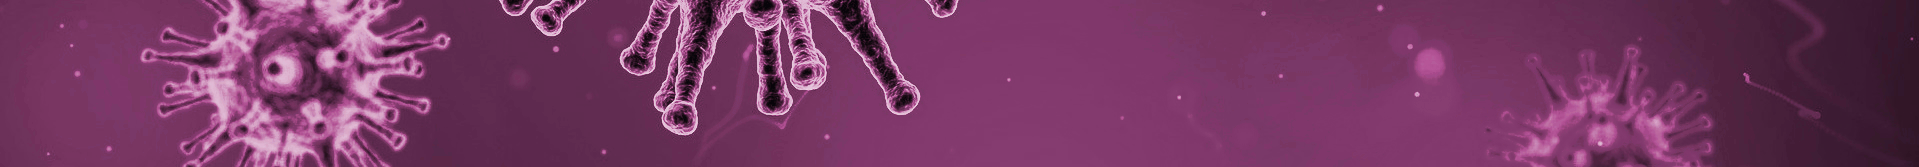

Now let's look at each state over time. This next visualization shows flu activity for a selected state (including Puerto Rico), where each line represents a different season.

In theory, we should see the same trend of darker lines appearing below brighter lines, indicating that when a state has a higher vaccination rate (darker line) the flu season is less severe.

Note that patterns may be hard to see since we're only looking at a few seasons. In particular, states whose vaccination rates are steady over time may only indicate the vaccine rate may need to be above a certain threshold to have a measurable effect. It's also important to note that vaccination rates only reach 70% at their highest.

In [28]:
#@title 3. Press play to select a state!

interactive(plotByState, state=state)

interactive(children=(Dropdown(description='State', index=4, options=('Alabama', 'Alaska', 'Arizona', 'Arkansa…

We can also compare states with consistent but differing vaccination rates, such as Hawaii and Louisiana. Hawaii tends to have high vaccination rates and the flu seasons tend to take longer to achieve high activity and wane more quickly than in Louisiana. Of course, many other factors may affect this.

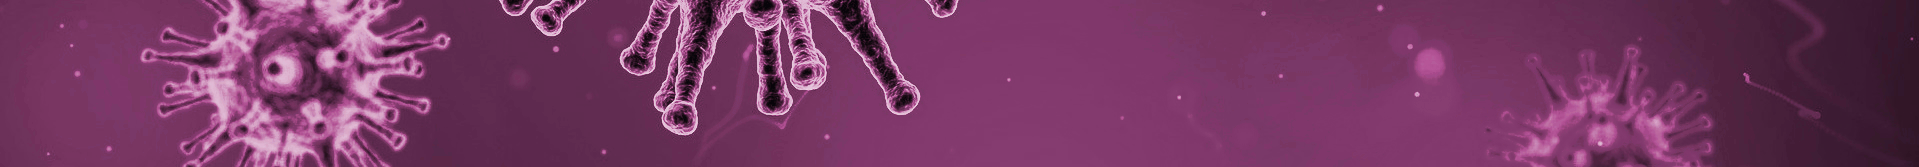

So what can we conclude, if anything? The data here is limited. Vaccination rates are generally low with little change and other factors affect flu season severity. Some strains of flu, due to their structure, naturally limit vaccine efficacy. But overall the pattern is there. Higher vaccination rates do seem to reduce flu activity. Have you gotten your flu shot yet?